In [1]:
# Code by Pranav Nagarajan
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy.interpolate import interp1d
from PyAstronomy import pyasl
from astropy import units as u
from astropy.coordinates import SkyCoord

In [2]:
# Read in the data
my_table = pd.read_csv('Blue_Supergiant_Data.csv')


# Calculate T_eff and associated error in units of 10000 K
temps = my_table.iloc[:, 1:2]*1e-4
temp_errors = my_table.iloc[:, 2:3]*1e-4


# Calculate log(T_eff^4) and its associated error
new_temp = 4*np.log10(temps)
new_temp_errors = 4*np.log10(np.e)*np.divide(np.array(temp_errors), np.array(temps))

my_table.insert(3, 'log (T_eff^4)', new_temp)
my_table.insert(4, 'log (T_eff^4) error', new_temp_errors)


# Calculate flux-weighted gravity and its associated error
flux_weighted_g = np.array(my_table['log g'] - my_table['log (T_eff^4)'])

g_error = np.multiply(my_table['log g error'], my_table['log g error'])
t_error = np.multiply(my_table['log (T_eff^4) error'], my_table['log (T_eff^4) error'])
tot_error = np.sqrt(g_error + t_error)

my_table.insert(7, 'log (flux-weighted gravity)', flux_weighted_g)
my_table.insert(8, 'error in log (flux-weighted gravity)', tot_error)

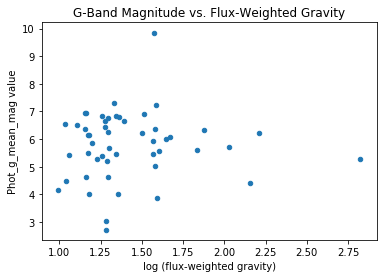

In [3]:
# Preliminary Graph
my_table.plot.scatter('log (flux-weighted gravity)', 'Phot_g_mean_mag value')
plt.title('G-Band Magnitude vs. Flux-Weighted Gravity')
plt.show()

In [4]:
# Defining functions to interpret RA and Dec and convert to Galactic Coordinates

def convert_to_decimal(coors):
    """Converts the RA and Dec columns in the table above to decimals."""
    
    coords = [str(coor).split(' ') for coor in coors]
    coords = [ls[:-1] if len(ls) > 3 else ls for ls in coords]
    coords = [string.lstrip('-') for ls in coords for string in ls]
    coords = [string.lstrip('0') for string in coords]
    coords = ['0' if string == '' else string for string in coords]

    decimals = []
    for i in range(len(coords)):
        if i % 3 == 0:
            if str(coors[int(i/3)])[0] == '-':
                decimals.append(-1*(eval(coords[i]) + eval(coords[i+1])/60 + eval(coords[i+2])/3600))
            else:
                decimals.append(eval(coords[i]) + eval(coords[i+1])/60 + eval(coords[i+2])/3600)
            
    return decimals

def convert_ra(ascen):
    """Converts input in decimal HMS to Degrees."""
    
    return np.array(ascen) * (360/24)
    
def convert_to_galactic(coors):
    """Converts a set of RA and Dec in degrees to galactic coordinates."""
    
    right_asc = coors[0]
    declination = coors[1]
    
    c_icrs = SkyCoord(ra=right_asc*u.degree, dec=declination*u.degree, frame='icrs')
    return c_icrs.galactic

In [5]:
# Optional: Converting RA and Dec to Galactic Longitude and Galatic Latitude

ra = np.array(my_table['RA (HMS)'])
dec = np.array(my_table['Dec (Degrees)'])

ascensions = convert_ra(convert_to_decimal(ra))
declinations = convert_to_decimal(dec)

coordinates = []
for ascension, decl in zip(ascensions, declinations):
    coordinates.append([ascension, decl])
    
galactic = [convert_to_galactic(coordinate) for coordinate in coordinates]
galactic = [[coor.l.degree, coor.b.degree] for coor in galactic]

glongs = [coor[0] for coor in galactic]
glats = [coor[1] for coor in galactic]

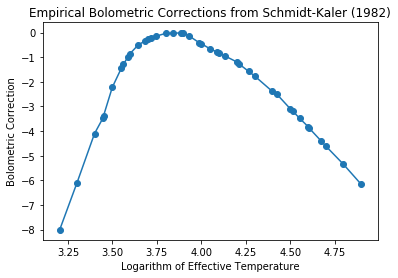

In [6]:
# Empiricial Bolometric Corrections from Schmidt-Kaler (1982)
temperatures = [79000, 63000, 50000, 40000, 31600, 25100, 20000, 15900, 12600, 10000, 7940, 6310, 5010, 3980, 3550, 3160, 2820, 2510, 2000, 1600]
bolometric = [-6.15, -5.35, -4.60, -3.83, -3.09, -2.39, -1.77, -1.20, -0.82, -0.45, 0.00, -0.03, -0.27, -0.85, -1.45, -2.22, -3.38, -4.1, -6.1, -8]

temperatures.extend([47300, 40300, 35700, 32600, 26500, 18500, 16200, 13600, 12200, 11200, 9730, 8510, 7700, 6900, 5550, 5200, 4850, 4420, 3850, 3650, 2800])
bolometric.extend([-4.41, -3.87, -3.48, -3.18, -2.49, -1.58, -1.26, -0.95, -0.78, -0.66, -0.41, -0.13, -0.01, -0.03, -0.15, -0.21, -0.33, -0.50, -1.01, -1.29, -3.47])

# Convert arrays into data points
domain = np.log10(np.array(temperatures))
combined = []
for x, y in zip(domain, bolometric):
    combined.append([x, y])

# Sort by log(T_eff)
combined.sort(key = lambda my_list: my_list[0])
combined = np.array(combined)

# Split into domain and range
log_t = combined[:, 0]
bc = combined[:, 1]

# Plot and interpolate 
plt.scatter(log_t, bc)
f = interp1d(log_t, bc, kind = 'quadratic')
plt.plot(log_t, f(log_t))
plt.title('Empirical Bolometric Corrections from Schmidt-Kaler (1982)')
plt.xlabel('Logarithm of Effective Temperature')
plt.ylabel('Bolometric Correction')
plt.show()

In [7]:
# Use interpolated function to compute bolometric corrections
our_temps = np.log10(my_table['T_eff (K)'])
predicted_bc = f(our_temps)
my_table['Bolometric Corrections'] = predicted_bc

In [8]:
# Convert effective temperature into intrinsic color index
converter = pyasl.BallesterosBV_T()
intrinsic_color_index = [converter.t2bv(temp) for temp in my_table['T_eff (K)']]
my_table['Intrinsic Color Index'] = intrinsic_color_index

In [9]:
# Calculate observed color index
observed_color_index = my_table['B-Band Apparent Magnitude'] - my_table['V-Band Apparent Magnitude']
my_table['Observed Color Index'] = observed_color_index

# Calculate interstellar reddening and extinction
reddening = observed_color_index  - intrinsic_color_index
extinction = 3.1*reddening
my_table['Interstellar Redenning'] = reddening
my_table['Extinction'] = extinction

In [10]:
def calc_absolute_magnitude(mag, distance, extinction):
    """Calculates absolute magnitude based on apparent magnitude, distance, and extinction."""
    
    return mag - 5*np.log10(distance/10) - extinction    

In [11]:
# Calculate absolute magnitudes based on distances from Bailer-Jones (2018)
v = my_table['V-Band Apparent Magnitude']
distances = my_table['Distance (pc)']

absolute_magnitude = [calc_absolute_magnitude(*group) for group in zip(v, distances, extinction)]
my_table['Absolute Magnitude'] = absolute_magnitude

# Calculate bolometric magnitude
my_table['Bolometric Magnitude'] = absolute_magnitude + my_table['Bolometric Corrections']

In [12]:
# Calculate asymmetric error bounds on bolometric magnitudes

upper_dist = my_table['Upper Bound (pc)']
lower_dist = my_table['Lower Bound (pc)']

abs_mag_upper = [calc_absolute_magnitude(*group) for group in list(zip(v, upper_dist, extinction))]
abs_mag_lower = [calc_absolute_magnitude(*group) for group in list(zip(v, lower_dist, extinction))]

my_table['Absolute Magnitude (Upper Bound)'] = abs_mag_upper
my_table['Absolute Magnitude (Lower Bound)'] = abs_mag_lower

my_table['Bolometric Magnitude (Upper Bound)'] = abs_mag_upper + my_table['Bolometric Corrections']
my_table['Bolometric Magnitude (Lower Bound)'] = abs_mag_lower + my_table['Bolometric Corrections']

In [13]:
# Compute vertical error bars

bolo = my_table['Bolometric Magnitude']
bolo_upper = my_table['Bolometric Magnitude (Upper Bound)']
bolo_lower = my_table['Bolometric Magnitude (Lower Bound)']

bolo_err = np.array(list(zip(abs(bolo-bolo_lower), abs(bolo-bolo_upper))))
err_low = bolo_err[:, 0]
err_high = bolo_err[:, 1]

In [14]:
import pwlf

def piecewise_linear_fit(x, y):
    """Returns the slopes and intercepts of a piecewise linear fit."""
    
    # Initialize the piecewise linear fit
    my_pwlf = pwlf.PiecewiseLinFit(x, y)

    # Piecewise linear fit with two line segments
    breaks = my_pwlf.fit(2)
    #breaks = my_pwlf.fit_guess([1.70])
    
    # Compute slopes and intercepts
    slopes = my_pwlf.slopes
    intercepts = my_pwlf.intercepts + slopes*1.5
    
    return [breaks, slopes, intercepts]

In [15]:
# Inspired by Alex Lewis
# https://stackoverflow.com/questions/23902157/how-to-calculate-errors-on-slopes-of-linear-fits-when-y-errors-are-asymmetric

from random import choice, gauss
from scipy.stats import linregress

def sim_normal(vals, errors):
    """Simulates a new x-value given the x-value of a data point and the error."""
    
    sim_normal = []
    
    for val, err in zip(vals, errors):
        
        # Choose upper bound or lower bound
        sigma = choice([-err, err])
        
        # Assume chosen error is normally distributed
        result = val + abs(gauss(0.0, 1.0)) * sigma
        
        # Add noise to data point and append to storage array
        sim_normal.append(result)

    return sim_normal

def split_normal(vals, low_errors, high_errors):
    """Simulates a new y-value given the y-value of a data point and the asymmetric error bounds."""

    split_normal = []
    
    # Loop over all data points
    for val, low_err, high_err in zip(vals, low_errors, high_errors):
        
        # Choose upper bound or lower bound
        sigma = choice([-low_err, high_err])
        
        # Assume chosen error is normally distributed
        result = val + abs(gauss(0.0, 1.0)) * sigma
        
        # Add noise to data point and append to storage array
        split_normal.append(result)

    return split_normal

def confidence_interval(x):
    """Returns 1-sigma error bounds on calculated slope and intercept."""
    
    # Compute indices of 16th percentile, median, and 84th percentile.
    index_16 = int(round(len(x) * 0.15865))
    index_med = len(x) // 2 
    index_84 = int(round(len(x) * 0.84135)) 

    # Compute median value
    x_sorted = sorted(x)
    median = x_sorted[index_med]
    
    # Compute lower and upper error bounds
    lower_bound = median - x_sorted[index_16] 
    upper_bound = x_sorted[index_84] - median 

    return median, lower_bound, upper_bound

def asymmetric_fit(x, y, x_err, low_err, high_err, n = 1000):
    """Runs linear regression for symmetric error bounds in the x-values 
    and asymmetric error bounds in the y-values."""

    slopes = []
    intercepts = []
    
    # Find parameter values through simulation
    for i in range(n):
        x_new = sim_normal(x, x_err)
        y_new = split_normal(y, low_err, high_err)
        par = sp.stats.linregress(x_new, y_new)

        slopes.append(par[0])
        intercepts.append(par[1] + 1.5*par[0])

    # Compute error bounds on parameters
    m, m_low, m_high = confidence_interval(slopes)
    b, b_low, b_high = confidence_interval(intercepts)

    return m, m_low, m_high, b, b_low, b_high

def asymmetric_piecewise_fit(x, y, x_err, low_err, high_err, n = 1000):
    """Runs piecewise linear regression for symmetric error bounds in the x-values 
    and asymmetric error bounds in the y-values."""

    low_slopes = []
    low_intercepts = []
    high_slopes = []
    high_intercepts = []
    breakpoints = []
    
    # Find parameter values through simulation
    for i in range(n):
        #x_new = sim_normal(x, x_err)
        y_new = split_normal(y, low_err, high_err)
        par = piecewise_linear_fit(x, y_new)

        low_slopes.append(par[1][0])
        low_intercepts.append(par[2][0])
        high_slopes.append(par[1][1])
        high_intercepts.append(par[2][1])
        breakpoints.append(par[0][1])
        
        if (i+1) % 100 == 0:
            print(i+1, ' trials have been completed!')

    # Compute error bounds on parameters
    m1, m1_low, m1_high = confidence_interval(low_slopes)
    m2, m2_low, m2_high = confidence_interval(high_slopes)
    b1, b1_low, b1_high = confidence_interval(low_intercepts)
    b2, b2_low, b2_high = confidence_interval(high_intercepts)
    p, p_low, p_high = confidence_interval(breakpoints)

    return m1, m1_low, m1_high, m2, m2_low, m2_high, b1, b1_low, b1_high, b2, b2_low, b2_high, p, p_low, p_high

In [16]:
# Simple Linear Regression with Errors in x and y
fg = my_table['log (flux-weighted gravity)']
fg_err = my_table['error in log (flux-weighted gravity)']

params = asymmetric_fit(fg, bolo, fg_err, err_low, err_high)

print('Slope:', params[0])
print('Slope Error:', [params[1], params[2]], '\n')
print('Intercept:', params[3])
print('Intercept Error:', [params[4], params[5]])

Slope: 3.5295242067238526
Slope Error: [0.31332459244929467, 0.34670731419923984] 

Intercept: -7.991679983319434
Intercept Error: [0.12473501012496335, 0.13427400219192975]


In [17]:
# Running Multiple Trials of Simple Linear Regression

slopes = []
slope_low = []
slope_high = []
intercepts = []
intercept_low = []
intercept_high = []

for i in range(100):
    params = asymmetric_fit(fg, bolo, fg_err, err_low, err_high)
    slopes.append(params[0])
    slope_low.append(params[1])
    slope_high.append(params[2])
    intercepts.append(params[3])
    intercept_low.append(params[4])
    intercept_high.append(params[5])
    
print('Slope Statistics: ', np.mean(slopes), np.mean(slope_low), np.mean(slope_high))
print('Intercept Statistics: ', np.mean(intercepts), np.mean(intercept_low), np.mean(intercept_high))

Slope Statistics:  3.550652682042482 0.3252675510495897 0.3501908748602179
Intercept Statistics:  -7.981828821176792 0.1310818029935613 0.1332957213207629


In [18]:
# Piecewise Linear Regression of FGLR
pars = asymmetric_piecewise_fit(fg, bolo, fg_err, err_low, err_high)

100  trials have been completed!
200  trials have been completed!
300  trials have been completed!
400  trials have been completed!
500  trials have been completed!
600  trials have been completed!
700  trials have been completed!
800  trials have been completed!
900  trials have been completed!
1000  trials have been completed!


In [19]:
# Data Exploration: Random Simulation in y

data_points = np.array(list(map(list, zip(fg, bolo, fg_err, err_low, err_high))))

break_point = pars[12]
low_points = [pair for pair in data_points if pair[0] < break_point]
high_points = [pair for pair in data_points if pair[0] >= break_point]

print('Split of Data:', len(low_points), len(high_points), '\n')
print('Low Parameters:', pars[0], pars[6])
print('Low Errors:', [pars[1], pars[2]], [pars[7], pars[8]], '\n')
print('High Parameters:', pars[3], pars[9])
print('High Errors:', [pars[4], pars[5]], [pars[10], pars[11]], '\n')
print('Breakpoint:', break_point)
print('Breakpoint Errors:', [pars[13], pars[14]])

Split of Data: 43 7 

Low Parameters: 6.450294296866067 -7.585644799341935
Low Errors: [0.5497903173955789, 0.6721256329790819] [0.12051167470232294, 0.18384888416828638] 

High Parameters: 3.366409004288143 -7.0349250977588795
High Errors: [0.16522557267863025, 0.23494594732569052] [0.20076271963084125, 0.14175542622152548] 

Breakpoint: 1.6686731998975284
Breakpoint Errors: [0.0842439443164793, 0.09071289907388724]


In [20]:
# Data Exploration: Random Simulation in x and y

data_points = np.array(list(map(list, zip(fg, bolo, fg_err, err_low, err_high))))

break_point = pars[12]
low_points = [pair for pair in data_points if pair[0] < break_point]
high_points = [pair for pair in data_points if pair[0] >= break_point]

print('Split of Data:', len(low_points), len(high_points), '\n')
print('Low Parameters:', pars[0], pars[6])
print('Low Errors:', [pars[1], pars[2]], [pars[7], pars[8]], '\n')
print('High Parameters:', pars[3], pars[9])
print('High Errors:', [pars[4], pars[5]], [pars[10], pars[11]], '\n')
print('Breakpoint:', break_point)
print('Breakpoint Errors:', [pars[13], pars[14]])

Split of Data: 43 7 

Low Parameters: 6.450294296866067 -7.585644799341935
Low Errors: [0.5497903173955789, 0.6721256329790819] [0.12051167470232294, 0.18384888416828638] 

High Parameters: 3.366409004288143 -7.0349250977588795
High Errors: [0.16522557267863025, 0.23494594732569052] [0.20076271963084125, 0.14175542622152548] 

Breakpoint: 1.6686731998975284
Breakpoint Errors: [0.0842439443164793, 0.09071289907388724]


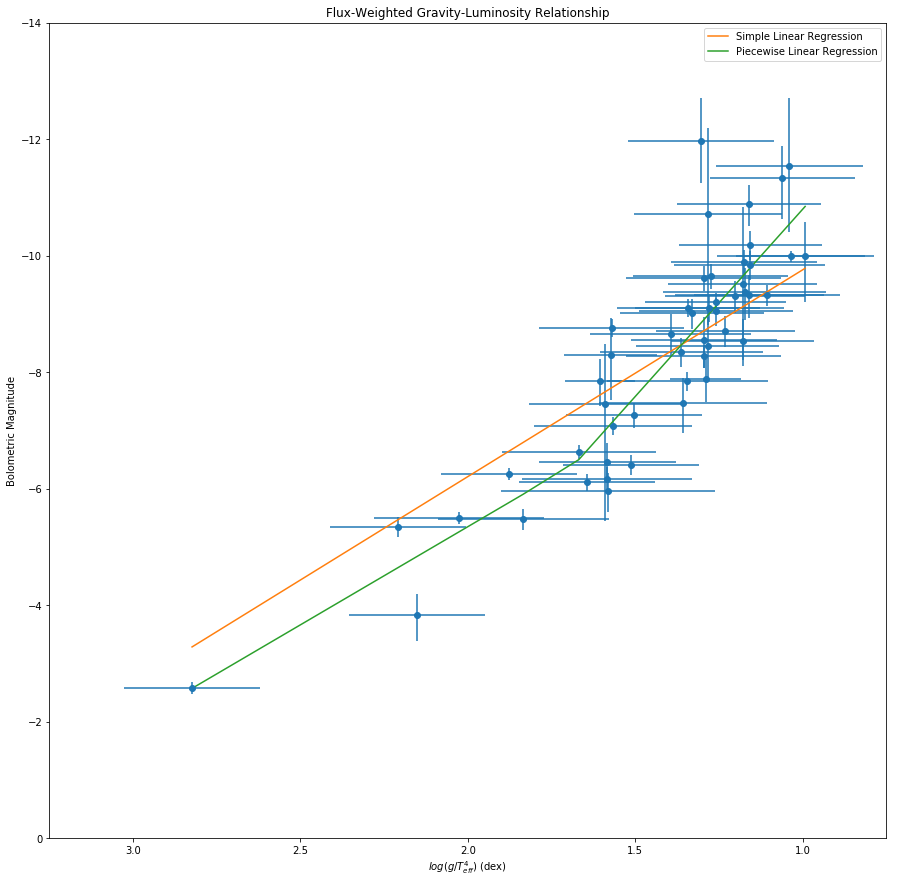

In [21]:
# Plot FGLR for Blue Supergiants
data_vals = np.array(sorted(np.array(zip(fg, bolo)).tolist()))
x_vals = data_vals[:, 0]
y_vals_true = data_vals[:, 1]
y_vals_simple = [3.55*(f-1.5) - 7.98 for f in x_vals]
y_vals_piecewise = [3.37*(f-1.5) - 7.03 if f > 1.7 else 6.43*(f-1.5) - 7.58 for f in x_vals]

plt.figure(figsize = (15, 15))
plt.errorbar(fg, bolo, xerr = fg_err, yerr = [err_low, err_high], fmt = 'o', label = None)
plt.plot(x_vals, y_vals_simple, label = 'Simple Linear Regression')
plt.plot(x_vals, y_vals_piecewise, label = 'Piecewise Linear Regression')
plt.title('Flux-Weighted Gravity-Luminosity Relationship')
plt.xlabel('$log(g/T_{eff}^{4})$ (dex)')
plt.ylabel('Bolometric Magnitude')
plt.legend()
plt.xlim(3.25, 0.75)
plt.ylim(0, -14)
plt.show()

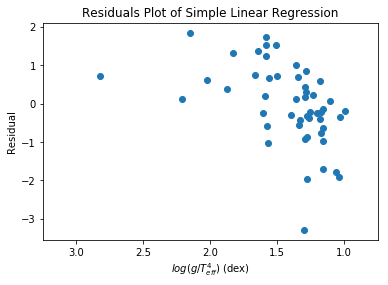

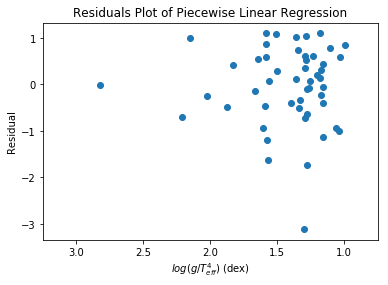

In [22]:
# Residuals Plot
plt.figure()
plt.scatter(x_vals, y_vals_true - y_vals_simple)
plt.title('Residuals Plot of Simple Linear Regression')
plt.xlabel('$log(g/T_{eff}^{4})$ (dex)')
plt.xlim(3.25, 0.75)
plt.ylabel('Residual')

plt.figure()
plt.scatter(x_vals, y_vals_true - y_vals_piecewise)
plt.title('Residuals Plot of Piecewise Linear Regression')
plt.xlabel('$log(g/T_{eff}^{4})$ (dex)')
plt.xlim(3.25, 0.75)
plt.ylabel('Residual')
plt.show()

In [23]:
# Final Data Table
my_table

ID  T_eff (K)  T_eff error  log (T_eff^4)  log (T_eff^4) error  \
0        Tr 14-30      26100         1300       1.666562             0.086526   
1      HD 111613*       9150          150      -0.154316             0.028478   
2   HD 92207 *(A)       9500          200      -0.089106             0.036572   
3       HD 161695       9950          200      -0.008708             0.034918   
4       HD 207673       9300          200      -0.126068             0.037359   
5        HD 14489       9000          200      -0.183030             0.038604   
6       HD 210221       8200          150      -0.344745             0.031778   
7        HD 46300       9700          200      -0.052913             0.035818   
8       HD 148743       7800          500      -0.431622             0.111358   
9        HD 13476       8400          150      -0.302883             0.031021   
10       HD 67456       8300          150      -0.323688             0.031395   
11      HD 195324       9300          200      -0.126068             0.037359   
12       HD 15316       8350          150      -0.313254             0.031207   
13       HD 30614      32500         1000       2.047533             0.053452   
14      HD 167264      29000         1000       1.849592             0.059903   
15      HD 204172      28500         1000       1.819379             0.060954   
16      HD 213087      26000         1000       1.659893             0.066815   
17        HD 2905      24000         1000       1.520845             0.072382   
18       HD 13854      23500         1000       1.484271             0.073922   
19       HD 24398      23000         1000       1.446911             0.075529   
20      HD 190603      21000         1000       1.288877             0.082723   
21       HD 14956      21500         1000       1.329754             0.080799   
22       HD 13841      22000         1000       1.369691             0.078963   
23      HD 193183      22500         1000       1.408730             0.077208   
24       HD 41117      19500         1000       1.160138             0.089086   
25       HD 14818      20000         1000       1.204120             0.086859   
26       HD 14143      20000         1000       1.204120             0.086859   
27      HD 194279      19000         1000       1.115014             0.091430   
28     HD 206165       20000         1000       1.204120             0.086859   
29       HD 31327      21500         1000       1.329754             0.080799   
30       HD 42087      20500         1000       1.247015             0.084740   
31      HD 198478      18000         1000       1.021090             0.096510   
32      HD 224055      17000         1000       0.921796             0.102187   
33      HD 225094      18000         1000       1.021090             0.096510   
34       HD 53138      18500         1000       1.068687             0.093902   
35       HD 14134      18000         1000       1.021090             0.096510   
36        HD 4841      14750         1000       0.675168             0.117775   
37        HD 7902      15500         1000       0.761327             0.112076   
38      HD 164353      16500         1000       0.869936             0.105284   
39      HD 191243      15500         1000       0.761327             0.112076   
40       HD 15497      15000         1000       0.704365             0.115812   
41       HD 13267      15000         1000       0.704365             0.115812   
42       HD 12301      14000         1000       0.584512             0.124084   
43      HD 199478      12500         1000       0.387640             0.138974   
44       HD 14542      12500         1000       0.387640             0.138974   
45      HD 208501      13000         1000       0.455773             0.133629   
46       HD 14322      13000         1000       0.455773             0.133629   
47       HD 21291      11500         1000       0.242791             0.151059   
48       HD 35600      11000         1000     